# The EGGROLL Recipe from Scratch

In this notebook, we reconstruct a simple version of our primary [Jax Codebase](https://github.com/ESHyperscale/HyperscaleES) to help people get started with their own creations using EGGROLL. This also serves as a detailed description of all the "quirks" of the EGGROLL codebase.

You can run this notebook on Google Colab with any device type (CPU, GPU, TPU) or on your own system as long as jax, optax, and matplotlib are installed.

## High-level Description of EGGROLL

**EGGROLL** stands for Evolution Guided General Optimization via Low-rank Learning. We recommend reading the project [homepage](https://eshyperscale.github.io) and [Lilian Weng's blog post on ES](https://lilianweng.github.io/posts/2019-09-05-evolution-strategies/) for a more detailed overview of EGGROLL and Evolution Strategies in general.

At a high level, the key idea is to use *low-rank perturbations*, calculate *fitnesses*, and construct an update using the fitness-weighted sum of perturbations.

$$ \nabla_{\theta}\mathbb{E}_{\epsilon_1, \epsilon_2 \sim N(0,I_{d})} F(\theta+\sigma\epsilon_2 \epsilon_1^T) = \frac{1}{\sigma}\mathbb{E}_{\epsilon_1,\epsilon_2\sim N(0,I_{d})}\{F(\theta+\sigma\epsilon_2 \epsilon_1^T)\epsilon_2 \epsilon_1^T\} $$

Naively computing $F(\theta+\sigma\epsilon_2 \epsilon_1^T)$ by materializing the full $\epsilon_2\epsilon_1^T$ matrix (which would be as large as the original matrix) would be very inefficient since it results in an expensive batched matrix multiplication. We would instead like to convert it into a regular matrix multiplication and cheap batched low-rank products.

This codebase is designed to easily extend EGGROLL to new problem settings by automatically handling the conversion of matrix multiplication to the low-rank updates with on-the-fly noise reconstructions.

## Part 1: The "Noiser"

Efficient EGGROLL requires converting the internals of matrix multiplications (between inputs and weights) into the "perturbed" matrix multiplication as defined by EGGROLL. For this, we define a **Noiser** which handles the way fundamental operations should be handled by our ES algorithm.

Below we show the *base noiser*, which performs no perturbations, but highlights the general interface of a noiser.

In [1]:
class Noiser:
    @classmethod
    def init_noiser(cls, params, sigma, lr, *args, solver=None, solver_kwargs=None, **kwargs):
        """
        params: parameters of the model
        sigma: initial sigma of noiser
        lr: learning rate of optimization process
        solver (optional, keyword arg): the optax solver to use (i.e. optax.adamw)
        solver_kwargs (optional, keyword arg): the optax solver's keyword arguments (excluding learning rate)

        Return frozen_noiser_params and noiser_params
        """
        return {}, {}

    @classmethod
    def do_mm(cls, frozen_noiser_params, noiser_params, param, base_key, iterinfo, x):
        return x @ param.T

    @classmethod
    def do_Tmm(cls, frozen_noiser_params, noiser_params, param, base_key, iterinfo, x):
        return x @ param

    @classmethod
    def get_noisy_standard(cls, frozen_noiser_params, noiser_params, param, base_key, iterinfo):
        return param

    @classmethod
    def convert_fitnesses(cls, frozen_noiser_params, noiser_params, raw_scores):
        return raw_scores

    @classmethod
    def do_updates(cls, frozen_noiser_params, noiser_params, params, base_keys, fitnesses, iterinfos, es_map):
        return noiser_params, params

There are a handful of "quirks" here to keep in mind. First, note that all methods are "class methods" which is an intentional choice to preserve the functional style of jax. Throughout this codebase, classes are collections of functions and do not store any internal state, and subclasses can inherit and override these functions, preventing code duplication. (The only exception to the above are NamedTuples which only store data but do not contain logic)

You may notice that the output of init_noiser is "frozen_noiser_params" and "noiser_params" and may ask why there are two separate outputs. Essentially, to preserve the "jit" compilation capabilities of jax, we only want to keep "frozen" data that the compiler should be aware of within frozen_noiser_params while other components, like large arrays or components that change, should be in noiser_params.

The key methods of Noiser for modifying the model behavior are do_mm, do_Tmm, and get_noisy_standard, which return noisy versions of these fundamental operations. The "get_noisy_standard" operation just noises a standard parameter that isn't involved in matmuls (like the bias and weight parameters of a layernorm). For each of these operations, you will notice two additional inputs: base_key and iterinfo.

The base_key is a jax PRNG key that is the "base" key for this parameter. The iterinfo is either None or is a tuple of (epoch, thread_id) to indicate which perturbation is currently being worked on. Note that "epoch" refers to the number of update steps that have already occurred and "thread_id" refers to the perturbation number within a single epoch.

**IMPORTANT:** iterinfo must be either None or a tuple of two ints. If you want to calculate multiple perturbations in parallel (which is the key component of EGGROLL), you need to use jax vmap, which we will explain in our worked-out example.

## Part 2: The "Model"

In our codebase, instead of directly interact with the Noiser, we define Models, which define how some network component is initialized and its forward pass.

Below we show the abstract base model and its general interface.

In [2]:
from typing import NamedTuple

PARAM = 0
MM_PARAM = 1
EXCLUDED=3

class CommonInit(NamedTuple):
    frozen_params: any
    params: any
    scan_map: any
    es_map: any

class CommonParams(NamedTuple):
    noiser: any
    frozen_noiser_params: any
    noiser_params: any
    frozen_params: any
    params: any
    es_tree_key: any
    iterinfo: any

class Model:
    @classmethod
    def rand_init(cls, key, *args, **kwargs):
        """
        Initialize model

        returns frozen_params, params, scan_map, es_map as CommonInit
        """
        raise NotImplementedError("Randomize Weights is not implemented")

    @classmethod
    def forward(cls,
                noiser, frozen_noiser_params, noiser_params,
                frozen_params, params, es_tree_key, iterinfo, *args, **kwargs):
        """
        Forward pass of model

        returns just the output
        """
        return cls._forward(CommonParams(noiser, frozen_noiser_params, noiser_params, frozen_params, params, es_tree_key, iterinfo), *args, **kwargs)

    @classmethod
    def _forward(cls, common_params, *args, **kwargs):
        raise NotImplementedError("Forward pass is not implemented")

As with the Noiser, there are multiple quirks with the Model.

The rand_init function takes in some jax PRNG key and outputs a "CommonInit" consisting of frozen_params, params, scan_map, and es_map. The frozen_params are just frozen aspects of the model (like some fixed configuration option), and params are the standard parameters of the model as a jax pytree (the actual weights and biases of the model).

For the purpose of this tutorial, scan_map can be mostly ignored, but it defines if a dimension of the parameter in a module is "scanned" over, which is only really relevant for LLMs; see the [rwkv7 implementation](https://github.com/ESHyperscale/HyperscaleES/blob/main/src/hyperscalees/models/llm/rwkv7.py) for an example usecase.

Finally, the es_map is a pytree of the same shape as params which dictates whether a model each component of the model should be treated as a PARAM, MM_PARAM, or EXCLUDED.

The forward function just defines the forward pass of the model. Most of the parameters are the same as we have explained before. Noiser is the Noiser (sub-)class and frozen_noiser_params and noiser_params are the outputs of init_noiser. The frozen_params and params are the outputs of rand_init. The iterinfo is the same as described earlier, either None or (epoch, thread_id).

The es_tree_key is a new parameter, and it is a tree of jax keys used to define the base_keys of the noiser.

Below is a list of general convenience methods used for combining Models.

In [3]:
import jax
import jax.numpy as jnp

def recursive_scan_split(param, base_key, scan_tuple):
    # scan_tuple = tuple() implies no split
    if len(scan_tuple) == 0:
        return base_key
    # otherwise, it is (0, 1, ...)
    split_keys = jax.random.split(base_key, param.shape[scan_tuple[0]])
    return jax.vmap(recursive_scan_split, in_axes=(None, 0, None))(param, split_keys, scan_tuple[1:])

def simple_es_tree_key(params, base_key, scan_map):
    vals, treedef = jax.tree.flatten(params)
    all_keys = jax.random.split(base_key, len(vals))
    partial_key_tree = jax.tree.unflatten(treedef, all_keys)
    return jax.tree.map(recursive_scan_split, params, partial_key_tree, scan_map)

def merge_inits(**kwargs):
    params = {}
    frozen_params = {}
    scan_map = {}
    es_map = {}
    for k in kwargs:
        params[k] = kwargs[k].params #k_params
        scan_map[k] = kwargs[k].scan_map #k_scan_map
        es_map[k] = kwargs[k].es_map #k_es_map
        if kwargs[k].frozen_params is not None:
            frozen_params[k] = kwargs[k].frozen_params
    if not frozen_params:
        frozen_params = None

    return CommonInit(frozen_params, params, scan_map, es_map)

def merge_frozen(common, **kwargs):
    new_frozen_params = common.frozen_params or {}
    new_frozen_params = new_frozen_params | kwargs
    return common._replace(frozen_params=new_frozen_params)

def call_submodule(cls, name, common_params, *args, **kwargs):
    sub_common_params = common_params._replace(
        frozen_params=common_params.frozen_params[name] if common_params.frozen_params and name in common_params.frozen_params else None,
        params=common_params.params[name],
        es_tree_key=common_params.es_tree_key[name]
    )
    return cls._forward(sub_common_params, *args, **kwargs)

The simple_es_tree_key generates the es_tree_key used for Model forward passes.

The other methods are helpers used to compose existing Model "submodules" into a larger module.

The fundamental, atomic Model classes are Parameter, MM, and TMM, implemented below:

In [4]:
class Parameter(Model):
    @classmethod
    def rand_init(cls, key, shape, scale, raw_value, dtype, *args, **kwargs):
        if raw_value is not None:
            params = raw_value.astype(dtype=dtype)
        else:
            params = (jax.random.normal(key, shape) * scale).astype(dtype=dtype)

        frozen_params = None
        scan_map = ()
        es_map = PARAM
        return CommonInit(frozen_params, params, scan_map, es_map)

    @classmethod
    def _forward(cls, common_params, *args, **kwargs):
        return common_params.noiser.get_noisy_standard(common_params.frozen_noiser_params, common_params.noiser_params, common_params.params, common_params.es_tree_key, common_params.iterinfo)

class MM(Model):
    @classmethod
    def rand_init(cls, key, in_dim, out_dim, dtype, *args, **kwargs):
        scale = 1 / jnp.sqrt(in_dim)
        params = (jax.random.normal(key, (out_dim, in_dim)) * scale).astype(dtype=dtype)
        frozen_params = None
        scan_map = ()
        es_map = MM_PARAM
        return CommonInit(frozen_params, params, scan_map, es_map)

    @classmethod
    def _forward(cls, common_params, x, *args, **kwargs):
        return common_params.noiser.do_mm(common_params.frozen_noiser_params, common_params.noiser_params, common_params.params, common_params.es_tree_key, common_params.iterinfo, x)

class TMM(Model):
    @classmethod
    def rand_init(cls, key, in_dim, out_dim, dtype, *args, **kwargs):
        scale = 1 / jnp.sqrt(in_dim)
        params = jax.random.normal(key, (in_dim, out_dim), dtype=dtype) * scale
        frozen_params = None
        scan_map = ()
        es_map = MM_PARAM
        return CommonInit(frozen_params, params, scan_map, es_map)

    @classmethod
    def _forward(cls, common_params, x, *args, **kwargs):
        return common_params.noiser.do_Tmm(common_params.frozen_noiser_params, common_params.noiser_params, common_params.params, common_params.es_tree_key, common_params.iterinfo, x)


These fundamental Model classes can then be composed into more complex neural networks. We implement Linear layers and MLPs below.

In [5]:
def layer_norm(x, eps=1e-5):
    mean = jnp.mean(x, axis=-1, keepdims=True)
    var = jnp.var(x, axis=-1, keepdims=True)
    std = jnp.sqrt(var + eps)
    return (x - mean) / std

ACTIVATIONS = {
    'relu': jax.nn.relu,
    'silu': jax.nn.silu,
    'pqn': lambda x: jax.nn.relu(layer_norm(x))
}

class Linear(Model):
    @classmethod
    def rand_init(cls, key, in_dim, out_dim, use_bias, dtype, *args, **kwargs):
        if use_bias:
            return merge_inits(
                weight=MM.rand_init(key, in_dim, out_dim, dtype),
                bias=Parameter.rand_init(key, None, None, jnp.zeros(out_dim, dtype=dtype), dtype)
            )
        else:
            return merge_inits(
                weight=MM.rand_init(key, in_dim, out_dim, dtype),
            )

    @classmethod
    def _forward(cls, common_params, x, *args, **kwargs):
        ans = call_submodule(MM, 'weight', common_params, x)
        if "bias" in common_params.params:
            ans += call_submodule(Parameter, 'bias', common_params)
        return ans

class MLP(Model):
    @classmethod
    def rand_init(cls, key, in_dim, out_dim, hidden_dims, use_bias, activation, dtype, *args, **kwargs):
        input_dims = [in_dim] + list(hidden_dims)
        output_dims = list(hidden_dims) + [out_dim]

        all_keys = jax.random.split(key, len(input_dims))

        merged_params = merge_inits(**{str(t): Linear.rand_init(all_keys[t], input_dims[t], output_dims[t], use_bias, dtype) for t in range(len(input_dims))})
        return merge_frozen(merged_params, activation=activation)

    @classmethod
    def _forward(cls, common_params, x, *args, **kwargs):
        num_blocks = len(common_params.params)
        for t in range(num_blocks):
            x = call_submodule(Linear, str(t), common_params, x)
            if t != num_blocks - 1:
                x = ACTIVATIONS[common_params.frozen_params['activation']](x)
        return x

## Part 3: The EGGROLL Noiser

Now that we have established an interface for the Noiser and Model, we are ready to implement the EGGROLL noiser.

In [6]:
import optax

from functools import partial

def get_sign_key(frozen_noiser_params, iterinfo, key):
    epoch, thread_id = iterinfo
    true_epoch = 0 if frozen_noiser_params["noise_reuse"] == 0 else epoch // frozen_noiser_params["noise_reuse"]
    true_thread_idx = thread_id // 2
    sign = jnp.where(thread_id % 2 == 0, 1, -1)
    key = jax.random.fold_in(jax.random.fold_in(key, true_epoch), true_thread_idx)
    return sign, key

def get_lora_update_params(frozen_noiser_params, base_sigma, iterinfo, param, key):
    sign, p_key = get_sign_key(frozen_noiser_params, iterinfo, key)
    sigma = base_sigma * sign

    a, b = param.shape
    lora_params = jax.random.normal(p_key, (a+b, frozen_noiser_params["rank"]), dtype=param.dtype)
    B = lora_params[:b] # b x r
    A = lora_params[b:] # a x r

    # update is A @ B.T
    return A * sigma, B

def get_nonlora_update_params(frozen_noiser_params, base_sigma, iterinfo, param, key):
    sign, p_key = get_sign_key(frozen_noiser_params, iterinfo, key)
    sigma = base_sigma * sign
    updates = jax.random.normal(p_key, param.shape, dtype=param.dtype)
    return updates * sigma

def _simple_full_update(base_sigma, param, key, scores, iterinfo, frozen_noiser_params):
    if frozen_noiser_params["freeze_nonlora"]:
        return jnp.zeros_like(param)
    _, thread_ids = iterinfo
    sigma = jnp.where(thread_ids % 2 == 0, base_sigma, -base_sigma)
    updates = jax.vmap(partial(get_nonlora_update_params, frozen_noiser_params), in_axes=(None, 0, None, None))(base_sigma, iterinfo, param, key)
    broadcasted_scores = jnp.reshape(scores, scores.shape + (1,) * len(param.shape))
    broadcasted_sigma = jnp.reshape(sigma, sigma.shape + (1,) * len(param.shape))
    return jnp.astype(jnp.mean(broadcasted_scores * updates, axis=0), param.dtype)

def _simple_lora_update(base_sigma, param, key, scores, iterinfo, frozen_noiser_params):
    A, B = jax.vmap(partial(get_lora_update_params, frozen_noiser_params), in_axes=(None, 0, None, None))(base_sigma / jnp.sqrt(frozen_noiser_params["rank"]), iterinfo, param, key)
    broadcasted_scores = jnp.reshape(scores, scores.shape + (1,1))
    A = broadcasted_scores * A # N x a x r for A vs N x b x r for B -> final update is just a x b
    num_envs = scores.shape[0]
    # return A.T @ B / num_envs
    return jnp.einsum('nir,njr->ij', A, B) / num_envs

def _noop_update(base_sigma, param, key, scores, iterinfo, frozen_noiser_params):
    return jnp.zeros_like(param)

class EggRoll(Noiser):
    @classmethod
    def init_noiser(cls, params, sigma, lr, *args, solver=None, solver_kwargs=None, group_size=0, freeze_nonlora=False, noise_reuse=1, rank=1, **kwargs):
        """
        Return frozen_noiser_params and noiser_params
        """
        if solver is None:
            solver = optax.sgd
        if solver_kwargs is None:
            solver_kwargs = {}
        true_solver = solver(lr, **solver_kwargs)
        opt_state = true_solver.init(params)

        return {"group_size": group_size, "freeze_nonlora": freeze_nonlora, "noise_reuse": noise_reuse, "solver": true_solver, "rank": rank}, {"sigma": sigma, "opt_state": opt_state}

    @classmethod
    def do_mm(cls, frozen_noiser_params, noiser_params, param, base_key, iterinfo, x):
        base_ans = x @ param.T
        if iterinfo is None:
            return base_ans
        A, B = get_lora_update_params(frozen_noiser_params, noiser_params["sigma"] / jnp.sqrt(frozen_noiser_params["rank"]), iterinfo, param, base_key)
        return base_ans + x @ B @ A.T

    @classmethod
    def do_Tmm(cls, frozen_noiser_params, noiser_params, param, base_key, iterinfo, x):
        base_ans = x @ param
        if iterinfo is None:
            return base_ans
        A, B = get_lora_update_params(frozen_noiser_params, noiser_params["sigma"] / jnp.sqrt(frozen_noiser_params["rank"]), iterinfo, param, base_key)
        return base_ans + x @ A @ B.T

    @classmethod
    def get_noisy_standard(cls, frozen_noiser_params, noiser_params, param, base_key, iterinfo):
        if iterinfo is None or frozen_noiser_params["freeze_nonlora"]:
            return param
        return param + get_nonlora_update_params(frozen_noiser_params, noiser_params["sigma"], iterinfo, param, base_key)

    @classmethod
    def convert_fitnesses(cls, frozen_noiser_params, noiser_params, raw_scores, num_episodes_list=None):
        group_size = frozen_noiser_params["group_size"]
        if group_size == 0:
            true_scores = (raw_scores - jnp.mean(raw_scores, keepdims=True)) / jnp.sqrt(jnp.var(raw_scores, keepdims=True) + 1e-5)
        else:
            group_scores = raw_scores.reshape((-1, group_size))
            true_scores = (group_scores - jnp.mean(group_scores, axis=-1, keepdims=True)) / jnp.sqrt(jnp.var(raw_scores, keepdims=True) + 1e-5)
            true_scores = true_scores.ravel()
        return true_scores

    @classmethod
    def _do_update(cls, param, base_key, fitnesses, iterinfos, map_classification, sigma, frozen_noiser_params, **kwargs):
        update_fn = [_simple_full_update, _simple_lora_update, _noop_update, _noop_update][map_classification]

        if len(base_key.shape) == 0:
            new_grad = update_fn(sigma, param, base_key, fitnesses, iterinfos, frozen_noiser_params)
        else:
            new_grad = jax.lax.scan(lambda _, x: (0, update_fn(sigma, x[0], x[1], fitnesses, iterinfos, frozen_noiser_params)), 0, xs=(param, base_key))[1]

        return -(new_grad * jnp.sqrt(fitnesses.size)).astype(param.dtype)

    @classmethod
    def do_updates(cls, frozen_noiser_params, noiser_params, params, base_keys, fitnesses, iterinfos, es_map):
        new_grad = jax.tree.map(lambda p, k, m: cls._do_update(p, k, fitnesses, iterinfos, m, noiser_params["sigma"], frozen_noiser_params), params, base_keys, es_map)
        updates, noiser_params["opt_state"] = frozen_noiser_params["solver"].update(new_grad, noiser_params["opt_state"], params)
        return noiser_params, optax.apply_updates(params, updates)

Note how EGGROLL transforms do_mm (and do_Tmm) by decomposing it into the base matrix multiplication and then multiplying by the lora components. Also notice how the _do_update function returns the negative gradient, because this allows us to use standard optax optimizers (like sgd or adam) which typically attempt to minimize a loss function instead of maximizing a fitness function.

## Part 4: Hands-On Experiments
Now that we have an implementation of EGGROLL, let's test it out on a toy problem of modeling a simple function. Let's start by building the dataset.

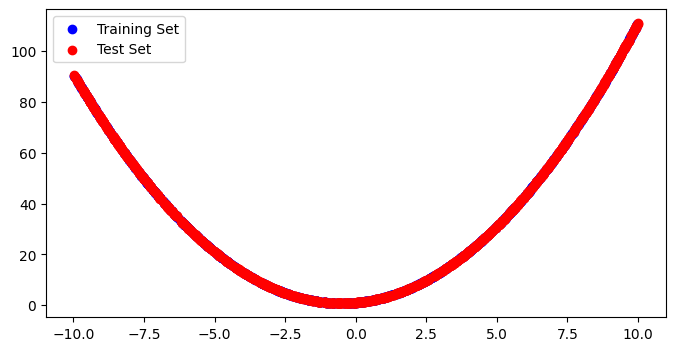

In [7]:
import matplotlib.pyplot as plt
max_x_dataset = 10
num_train_points = 1024
num_test_points = 1024

dataset_seed = 0
dataset_key = jax.random.key(dataset_seed)

train_key, test_key = jax.random.split(dataset_key)
train_x = jax.random.uniform(train_key, shape=(num_train_points,), minval=-max_x_dataset, maxval=max_x_dataset)
test_x = jax.random.uniform(test_key, shape=(num_train_points,), minval=-max_x_dataset, maxval=max_x_dataset)

def pred_fn(x):
    return x ** 2 + x + 1

train_y = pred_fn(train_x)
test_y = pred_fn(test_x)

plt.figure(figsize=(8, 4))
plt.scatter(train_x, train_y, label='Training Set', color='blue')
plt.scatter(test_x, test_y, label='Test Set', color='red')
plt.legend()
plt.show()

@jax.jit
def batch_calculate_fitness(y_pred, y_true):
    return -((y_pred-y_true) ** 2)

Next, let's initialize an MLP model that we will train alongside the EggRoll noiser.

In [8]:
NOISER = EggRoll
MODEL = MLP

num_envs = 4096  # number of unique perturbations

num_epochs = 1000
sigma = 1.0
lr = optax.schedules.linear_schedule(1.0, 0.0, num_epochs)
rank = 1
generations_per_prompt = 128  # needs to be even and divisor of num_envs

in_dim = 1
out_dim = 1
hidden_dim = 64
n_layer = 3

key = jax.random.key(1)
model_key = jax.random.fold_in(key, 0)
es_key = jax.random.fold_in(key, 1)

frozen_params, params, scan_map, es_map = MODEL.rand_init(
    model_key, in_dim=in_dim, out_dim=out_dim, hidden_dims=[hidden_dim] * n_layer, use_bias=True, activation="pqn", dtype="float32"
)

print("Frozen params:", frozen_params)
print("Params (shape):", jax.tree.map(lambda x: x.shape, params))
print("Scan map:", scan_map)
print("ES map:", es_map)

es_tree_key = simple_es_tree_key(params, es_key, scan_map)

print("ES Tree Key:", es_tree_key)

frozen_noiser_params, noiser_params = NOISER.init_noiser(params, sigma, lr, group_size=generations_per_prompt, rank=rank)
# frozen_noiser_params, noiser_params = NOISER.init_noiser(params, sigma, lr, solver=optax.adamw, solver_kwargs={"b1": 0.9, "b2": 0.999}, rank=rank)

Frozen params: {'activation': 'pqn'}
Params (shape): {'0': {'bias': (64,), 'weight': (64, 1)}, '1': {'bias': (64,), 'weight': (64, 64)}, '2': {'bias': (64,), 'weight': (64, 64)}, '3': {'bias': (1,), 'weight': (1, 64)}}
Scan map: {'0': {'weight': (), 'bias': ()}, '1': {'weight': (), 'bias': ()}, '2': {'weight': (), 'bias': ()}, '3': {'weight': (), 'bias': ()}}
ES map: {'0': {'weight': 1, 'bias': 0}, '1': {'weight': 1, 'bias': 0}, '2': {'weight': 1, 'bias': 0}, '3': {'weight': 1, 'bias': 0}}
ES Tree Key: {'0': {'bias': Array((), dtype=key<fry>) overlaying:
[3276925600 2751771740], 'weight': Array((), dtype=key<fry>) overlaying:
[2215249346  143550061]}, '1': {'bias': Array((), dtype=key<fry>) overlaying:
[3270805043 4194985171], 'weight': Array((), dtype=key<fry>) overlaying:
[1478684692 1965378429]}, '2': {'bias': Array((), dtype=key<fry>) overlaying:
[ 772271994 3484915418], 'weight': Array((), dtype=key<fry>) overlaying:
[2550017737  119053413]}, '3': {'bias': Array((), dtype=key<fry>

Now we can define the forward and update functions. Note that the regular "jit_forward" includes iterinfo to include the eggroll perturbations, whereas "jit_forward_eval" only uses the unperturbed base parameters.

In [9]:
# inputs are noiser_params, params, iterinfo, input
jit_forward = jax.jit(jax.vmap(lambda n, p, i, x: MODEL.forward(NOISER, frozen_noiser_params, n, frozen_params, p, es_tree_key, i, x), in_axes=(None, None, 0, 0)))
# inputs are noiser_params, params, input
jit_forward_eval = jax.jit(jax.vmap(lambda n, p, x: MODEL.forward(NOISER, frozen_noiser_params, n, frozen_params, p, es_tree_key, None, x), in_axes=(None, None, 0)))
# inputs are noiser_params, params, fitnesses, iterinfo
jit_update = jax.jit(lambda n, p, f, i: NOISER.do_updates(frozen_noiser_params, n, p, es_tree_key, f, i, es_map))

print("Warmup")
compile_iterinfos = (jnp.zeros(num_envs, dtype=jnp.int32), jnp.zeros(num_envs, dtype=jnp.int32))
tmp_forward_out = jax.block_until_ready(jit_forward(noiser_params, params, compile_iterinfos, jnp.zeros((num_envs, 1))))
print("forward compiled; output shape is", tmp_forward_out.shape)
tmp_forward_eval_out = jax.block_until_ready(jit_forward_eval(noiser_params, params, jnp.zeros((num_test_points, 1))))
print("forward eval compiled; output shape is", tmp_forward_eval_out.shape)
tmp_update_out = jax.block_until_ready(jit_update(noiser_params, params, jnp.zeros(num_envs), compile_iterinfos))
print("update compiled")

Warmup
forward compiled; output shape is (4096, 1)
forward eval compiled; output shape is (1024, 1)
update compiled


Finally, we can define the optimization loop

In [10]:
prompts_per_epoch = num_envs // generations_per_prompt

losses = []
all_data = []

for epoch in range(num_epochs):
    iterinfo = (jnp.full(num_envs, epoch, dtype=jnp.int32), jnp.arange(num_envs))

    # data loading
    unique_data_input_idxes = (jnp.arange(prompts_per_epoch) + epoch * prompts_per_epoch) % num_train_points
    indices = jnp.repeat(unique_data_input_idxes, generations_per_prompt, axis=0)
    train_batch_x = train_x[indices]
    train_batch_y = train_y[indices]

    # getting outputs from perturbations (THE KEY EGGROLL LOGIC)
    outputs_batch = jit_forward(noiser_params, params, iterinfo, train_batch_x[:, None])[:, 0]
    raw_scores = batch_calculate_fitness(outputs_batch, train_batch_y)
    fitnesses = NOISER.convert_fitnesses(frozen_noiser_params, noiser_params, raw_scores)
    noiser_params, params = jit_update(noiser_params, params, fitnesses, iterinfo)

    # evaluating the quality of the parameters on the test set
    test_batch = jit_forward_eval(noiser_params, params, test_x[:, None])[:, 0]
    all_data.append(test_batch)
    raw_test_fitness_scores = batch_calculate_fitness(test_batch, test_y)
    losses.append(-jnp.mean(raw_test_fitness_scores).item())
    if epoch % 10 == 0:
        print(f"({epoch}) Avg validation loss is {-jnp.mean(raw_test_fitness_scores)} (positive, lower is better)")

    # linear sigma decay
    noiser_params["sigma"] = sigma * (1 - epoch / num_epochs)

all_data = jnp.array(all_data)

(0) Avg validation loss is 1073.5396728515625 (positive, lower is better)
(10) Avg validation loss is 1035.8629150390625 (positive, lower is better)
(20) Avg validation loss is 3688.263671875 (positive, lower is better)
(30) Avg validation loss is 580.8432006835938 (positive, lower is better)
(40) Avg validation loss is 7196.927734375 (positive, lower is better)
(50) Avg validation loss is 683.9771728515625 (positive, lower is better)
(60) Avg validation loss is 472.10992431640625 (positive, lower is better)
(70) Avg validation loss is 982.5682373046875 (positive, lower is better)
(80) Avg validation loss is 627.3795166015625 (positive, lower is better)
(90) Avg validation loss is 371.49005126953125 (positive, lower is better)
(100) Avg validation loss is 470.04046630859375 (positive, lower is better)
(110) Avg validation loss is 1540.08642578125 (positive, lower is better)
(120) Avg validation loss is 549.3768310546875 (positive, lower is better)
(130) Avg validation loss is 433.75024

Let's plot how well it does!

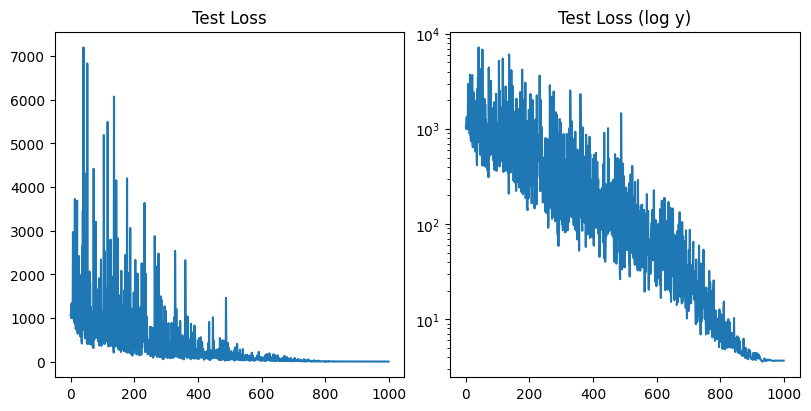

In [11]:
# plot loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained", figsize=(8, 4))
ax1.plot(range(num_epochs), losses)
ax1.set_title("Test Loss")

ax2.plot(range(num_epochs), losses)
ax2.set_yscale("log")
ax2.set_title("Test Loss (log y)")
plt.show()

In [12]:
from ipywidgets import interact
import ipywidgets as widgets

slider = widgets.IntSlider(min=0, max=num_epochs-1, step=1, value=num_epochs-1, description="Epoch Number:")

def update_slider(change):
    plt.gca().set_ylim(jnp.min(test_y) - 10, jnp.max(test_y) + 10)
    plt.scatter(test_x, test_y, label='Ground Truth', color='blue')
    plt.scatter(test_x, all_data[change, :], label='Model Predictions', color='green')
    plt.legend()
    plt.gca().set_title(f'Model reconstruction at Time Step: {change}')

_ = interact(update_slider, change=slider)

interactive(children=(IntSlider(value=999, description='Epoch Number:', max=999), Output()), _dom_classes=('wi…

Something to note is that we have not done any hyperparameter tuning for learning rate and sigma. Instead we start at 1.0 and perform a linear decay over the epochs. (This is extremely naive, since exponential decays are more typically used for evolution strategies and we would typically want to tune both hyperparameters anyways)

A fun follow-up exercise may be to try tuning the hyperparameters or trying different schedules. Additionally, we just use SGD for simplicity, but you can also try out different optimizers and see which ones improve performance.

## Conclusion

Congratulations! You have now trained your first toy network with EGGROLL. We recommend playing around with this script and checking different hyperparameters. The workflow used for this toy setting is very similar to that of more complicated problems; you just need to change the model, data loading, and fitness function to your new setting.

For those interested in extending EGGROLL to the RWKV LLMs or multi-gpu configurations, check out our [multi-gpu evolution script](https://github.com/ESHyperscale/HyperscaleES/blob/main/llm_experiments/general_do_evolution_multi_gpu.py).

## Part 5: MNIST with EGGROLL (JAX)

This section mirrors the notebook's EGGROLL workflow on MNIST. Each perturbation sees a single image, and fitness is shaped by the noiser's grouping.


In [13]:
%pip install --upgrade "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
%pip install tensorflow_datasets

import jax
print(jax.devices())

/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
[CudaDevice(id=0)]


In [14]:
import tensorflow_datasets as tfds

def load_mnist_flat():
    ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
    def to_array(ds):
        xs = []
        ys = []
        for x, y in tfds.as_numpy(ds):
            xs.append((x.astype('float32') / 255.0).reshape(-1))
            ys.append(y)
        return jnp.array(xs), jnp.array(ys, dtype=jnp.int32)

    train_x, train_y = to_array(ds_train)
    test_x, test_y = to_array(ds_test)
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = load_mnist_flat()
num_train_points = train_x.shape[0]
print('train_x', train_x.shape, 'train_y', train_y.shape)
print('test_x', test_x.shape, 'test_y', test_y.shape)


/home/andrew-peterson/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/andrew-peterson/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/andrew-peterson/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compa

train_x (60000, 784) train_y (60000,)
test_x (10000, 784) test_y (10000,)


In [15]:
@jax.jit
def batch_calculate_fitness(logits, labels):
    log_probs = jax.nn.log_softmax(logits)
    return log_probs[jnp.arange(labels.shape[0]), labels]


In [16]:
NOISER = EggRoll
MODEL = MLP

num_envs = 4096
num_epochs = 500
sigma = 0.05
lr = optax.schedules.linear_schedule(1.0, 0.0, num_epochs)
rank = 1
generations_per_prompt = 32

in_dim = 28 * 28
out_dim = 10
hidden_dim = 128
n_layer = 1

key = jax.random.key(42)
model_key = jax.random.fold_in(key, 0)
es_key = jax.random.fold_in(key, 1)

frozen_params, params, scan_map, es_map = MODEL.rand_init(
    model_key, in_dim=in_dim, out_dim=out_dim, hidden_dims=[hidden_dim] * n_layer, use_bias=True, activation='relu', dtype='float32'
)

es_tree_key = simple_es_tree_key(params, es_key, scan_map)
frozen_noiser_params, noiser_params = NOISER.init_noiser(
    params, sigma, lr, group_size=generations_per_prompt, rank=rank
)

jit_forward = jax.jit(jax.vmap(
    lambda n, p, i, x: MODEL.forward(NOISER, frozen_noiser_params, n, frozen_params, p, es_tree_key, i, x),
    in_axes=(None, None, 0, 0)
))
jit_forward_eval = jax.jit(jax.vmap(
    lambda n, p, x: MODEL.forward(NOISER, frozen_noiser_params, n, frozen_params, p, es_tree_key, None, x),
    in_axes=(None, None, 0)
))
jit_update = jax.jit(
    lambda n, p, f, i: NOISER.do_updates(frozen_noiser_params, n, p, es_tree_key, f, i, es_map)
)


In [17]:
import time
start_time = time.perf_counter()
prompts_per_epoch = num_envs // generations_per_prompt

losses = []
accs = []

for epoch in range(num_epochs):
    iterinfo = (jnp.full(num_envs, epoch, dtype=jnp.int32), jnp.arange(num_envs))

    unique_idx = (jnp.arange(prompts_per_epoch) + epoch * prompts_per_epoch) % num_train_points
    indices = jnp.repeat(unique_idx, generations_per_prompt, axis=0)
    train_batch_x = train_x[indices]
    train_batch_y = train_y[indices]

    logits = jit_forward(noiser_params, params, iterinfo, train_batch_x)
    raw_scores = batch_calculate_fitness(logits, train_batch_y)
    fitnesses = NOISER.convert_fitnesses(frozen_noiser_params, noiser_params, raw_scores)
    noiser_params, params = jit_update(noiser_params, params, fitnesses, iterinfo)

    test_logits = jit_forward_eval(noiser_params, params, test_x)
    test_loss = -jnp.mean(batch_calculate_fitness(test_logits, test_y)).item()
    test_pred = jnp.argmax(test_logits, axis=-1)
    test_acc = jnp.mean(test_pred == test_y).item()

    losses.append(test_loss)
    accs.append(test_acc)
    if epoch % 50 == 0:
        print(f'(epoch {epoch}) test_loss={test_loss:.4f} test_acc={test_acc:.4f}')

    noiser_params['sigma'] = sigma * (1 - epoch / num_epochs)
elapsed = time.perf_counter() - start_time
print(f"elapsed_seconds={elapsed:.2f}")


(epoch 0) test_loss=2.2946 test_acc=0.1632
(epoch 50) test_loss=1.1797 test_acc=0.6423
(epoch 100) test_loss=0.9869 test_acc=0.7164
(epoch 150) test_loss=0.9167 test_acc=0.7530
(epoch 200) test_loss=0.8680 test_acc=0.7662
(epoch 250) test_loss=0.8191 test_acc=0.7835
(epoch 300) test_loss=0.7865 test_acc=0.7911
(epoch 350) test_loss=0.7781 test_acc=0.7955
(epoch 400) test_loss=0.7729 test_acc=0.7951
(epoch 450) test_loss=0.7716 test_acc=0.7956
elapsed_seconds=9.41
